OPENAI_API_KEY found.
Loading transaction data...


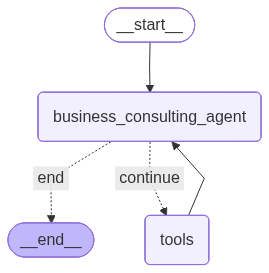

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain_core.tools import tool
from typing import Literal, Dict,TypedDict, Sequence, Annotated
from langchain_core.messages import HumanMessage,SystemMessage,AIMessage,ToolMessage,BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode

# -------------------------
# Load environment variables
# -------------------------
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY is missing.")
print("OPENAI_API_KEY found.")

# -------------------------
# Load transaction dataset (STRUCTURED DATA)
# -------------------------
print("Loading transaction data...")
df = pd.read_csv("../../data/processed_data/business_data.csv")


# -------------------------
# Policy documents (UNSTRUCTURED DATA)
# -------------------------
policy_docs = [
    Document(
        page_content="Refunds usually take 5-10 business days.",
        metadata={"source": "policy"},
    ),
    Document(
        page_content="Food items are non-refundable.",
        metadata={"source": "policy"},
    ),
    Document(
        page_content="Transactions above 500 EUR are flagged for review.",
        metadata={"source": "policy"},
    ),
    Document(
        page_content=(
            "Potential fraud indicators include high transaction frequency, "
            "unusual transaction amounts, and cross-border transactions."
        ),
        metadata={"source": "policy"},
    ),
]

# -------------------------
# Build RAG ONLY for policies
# -------------------------
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=50,
)

policy_chunks = text_splitter.split_documents(policy_docs)

embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    openai_api_key=OPENAI_API_KEY,
)

vectorstore = FAISS.from_documents(policy_chunks, embeddings)

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    openai_api_key=OPENAI_API_KEY,
)

retriever = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
)

# -------------------------
# Example queries
# -------------------------

#  Policy / reasoning (RAG)
# policy_question = "When are transactions flagged for review?"
# policy_answer = retriever.invoke({"query": policy_question})

# print("\nPolicy answer:")
# print(policy_answer["result"])

@tool
def get_transaction_field(transaction_id: int, field: str) -> str:
    """
    Get a specific field for a transaction.
    Allowed fields:
    transaction_id, customer_id, amount, currency, timestamp, category,
    currency_imputed, exchange_rate, amount_eur, country, signup_date,
    email, days_since_signup
    """
    if field not in df.columns:
        return f"Invalid field. Available fields are: {list(df.columns)}"

    row = df.loc[df["transaction_id"] == transaction_id]
    if row.empty:
        return "Transaction not found."

    return str(row.iloc[0][field])

@tool
def get_customer_transactions(customer_id: int) -> str:
    """
    Get a summary of transactions for a given customer.
    """
    rows = df.loc[df["customer_id"] == customer_id]

    if rows.empty:
        return "No transactions found for this customer."

    summary = rows[[
        "transaction_id", "amount", "currency", "country", "category"
    ]].head(5)

    return summary.to_string(index=False)

@tool
def policy_lookup(question: str) -> str:
    """
    Answer questions about company policies such as refunds,
    returns, fraud rules, and transaction reviews.
    """
    result = retriever.invoke({"query": question})
    return result["result"]


@tool
def get_transaction_summary(transaction_id: int) -> str:
    """
    Get a human-readable summary of a transaction.
    """
    row = df.loc[df["transaction_id"] == transaction_id]
    if row.empty:
        return "Transaction not found."

    r = row.iloc[0]

    return (
        f"Transaction {r.transaction_id}:\n"
        f"- Customer ID: {r.customer_id}\n"
        f"- Amount: {r.amount} {r.currency}\n"
        f"- Amount (EUR): {r.amount_eur}\n"
        f"- Category: {r.category}\n"
        f"- Country: {r.country}\n"
        f"- Date: {r.timestamp}\n"
        f"- Days since signup: {r.days_since_signup}"
    )

@tool
def get_transaction_amount(transaction_id: int) -> str:
    """
    Get amount details for a transaction.
    """
    row = df.loc[df["transaction_id"] == transaction_id]
    if row.empty:
        return "Transaction not found."

    r = row.iloc[0]

    return (
        f"Transaction {transaction_id} amount:\n"
        f"- Original: {r.amount} {r.currency}\n"
        f"- Converted: {r.amount_eur} EUR\n"
        f"- Exchange rate: {r.exchange_rate}"
    )

@tool
def get_customer_profile(customer_id: int) -> str:
    """
    Get customer profile and activity summary.
    """
    rows = df.loc[df["customer_id"] == customer_id]
    if rows.empty:
        return "Customer not found."

    first = rows.iloc[0]

    return (
        f"Customer {customer_id}:\n"
        f"- Email: {first.email}\n"
        f"- Signup date: {first.signup_date}\n"
        f"- Days since signup: {first.days_since_signup}\n"
        f"- Total transactions: {len(rows)}\n"
        f"- Countries used: {rows.country.nunique()}"
    )

@tool
def get_recent_transactions(customer_id: int, limit: int = 5) -> str:
    """
    Get recent transactions for a customer.
    """
    rows = df.loc[df["customer_id"] == customer_id]

    if rows.empty:
        return "No transactions found."

    rows = rows.sort_values("timestamp", ascending=False).head(limit)

    return rows[[
        "transaction_id",
        "amount",
        "currency",
        "country",
        "category",
        "timestamp",
    ]].to_string(index=False)

@tool
def check_cross_border(transaction_id: int) -> str:
    """
    Check if a transaction is cross-border.
    """
    row = df.loc[df["transaction_id"] == transaction_id]
    if row.empty:
        return "Transaction not found."

    country = row.iloc[0]["country"]

    return (
        f"Transaction {transaction_id} occurred in {country}. "
        "Cross-border transactions may require additional review."
    )

@tool
def check_high_value(transaction_id: int, threshold_eur: float = 500) -> str:
    """
    Check if transaction exceeds a EUR threshold.
    """
    row = df.loc[df["transaction_id"] == transaction_id]
    if row.empty:
        return "Transaction not found."

    amount_eur = row.iloc[0]["amount_eur"]

    if amount_eur > threshold_eur:
        return (
            f"Transaction {transaction_id} is high-value "
            f"({amount_eur} EUR) and may be reviewed."
        )

    return f"Transaction {transaction_id} is below the review threshold."

@tool
def get_customer_spending_by_category(customer_id: int) -> str:
    """
    Get spending breakdown by category for a customer.
    """
    rows = df.loc[df["customer_id"] == customer_id]

    if rows.empty:
        return "No transactions found."

    summary = (
        rows.groupby("category")["amount_eur"]
        .sum()
        .sort_values(ascending=False)
    )

    return summary.to_string()


@tool
def list_supported_currencies() -> str:
    """
    List all supported currencies in the system.
    """
    currencies = sorted(df["currency"].dropna().unique())
    return "Supported currencies: " + ", ".join(currencies)

@tool
def list_supported_countries() -> str:
    """
    List all countries where transactions have occurred.
    """
    countries = sorted(df["country"].dropna().unique())
    return "Supported countries: " + ", ".join(countries)

@tool
def list_transaction_categories() -> str:
    """
    List all transaction categories.
    """
    categories = sorted(df["category"].dropna().unique())
    return "Transaction categories: " + ", ".join(categories)

@tool
def average_transaction_amount() -> str:
    """
    Get the average transaction amount in EUR.
    """
    avg = df["amount_eur"].mean()
    return f"The average transaction amount is {avg:.2f} EUR."

@tool
def platform_statistics() -> str:
    """
    Get high-level platform statistics.
    """
    return (
        f"Platform statistics:\n"
        f"- Total transactions: {len(df)}\n"
        f"- Total customers: {df['customer_id'].nunique()}\n"
        f"- Average amount (EUR): {df['amount_eur'].mean():.2f}\n"
        f"- Countries served: {df['country'].nunique()}"
    )

@tool
def high_value_by_frequency() -> Dict:
    """
    Returns the top 5 customers with the highest number of transactions.
    """
    stats = df.groupby("customer_id").agg(
        transaction_count=("transaction_id", "count"),
        total_spend=("amount_eur", "sum")
    ).reset_index()

    # Top 5 customers by transaction count
    top_customers = stats.sort_values("transaction_count", ascending=False).head(5)
    
    return {
        "high_value_by_frequency": top_customers[["customer_id", "transaction_count"]].to_dict(orient="records")
    }

@tool
def high_value_by_spend() -> Dict:
    """
    Returns the top 5 customers with the highest total spend.
    """
    stats = business_data.groupby("customer_id").agg(
        transaction_count=("transaction_id", "count"),
        total_spend=("amount_eur", "sum")
    ).reset_index()

    # Top 5 customers by spend
    top_customers = stats.sort_values("total_spend", ascending=False).head(5)
    
    return {
        "high_value_by_spend": top_customers[["customer_id", "total_spend"]].to_dict(orient="records")
    }




# List of tools to bind to the LLM for enhanced contextual interaction with the supervisory agent
tools = [
    get_transaction_field,
    get_transaction_summary,
    get_transaction_amount,
    get_customer_profile,
    get_recent_transactions,
    get_customer_spending_by_category,
    check_cross_border,
    check_high_value,
    policy_lookup,
    list_supported_currencies,
    list_supported_countries,
    list_transaction_categories,
    average_transaction_amount,
    platform_statistics,
    high_value_by_frequency,
    high_value_by_spend,

]

# Bind the tools to the LLM to aid contextual interaction with the supervisory agent
llm = llm.bind_tools(tools) 

class BusinessConsultingAgentState(TypedDict):
    """Create a list of messages that the business consulting agent will use to interact with the supervisory agent."""
    messages: Annotated[Sequence[BaseMessage],add_messages]

def business_consulting_agent(state: BusinessConsultingAgentState) -> str:
    """
    Business consulting agent that interacts with the supervisory agent and uses tools to answer customer queries.
    """
    system_prompt = SystemMessage(
        content=(
            "You are a helpful and knowledgeable business consulting agent. "
            "You assist the supervisory agent by answering customer queries, "
            "providing transaction details, and explaining company policies. "
            "Use the available tools to retrieve information as needed."
        )
    )
        # Track the tool calls made by the supervisory agent to other agents
    print("[Agent] checking tools for calls...")
    
    # Invoke the LLM with the system prompt and the current messages in the state
    response = llm.invoke([system_prompt] + state['messages'])

    # Track Tools
    print("Checking for tool calls...")
    for i, tool_call in enumerate(response.tool_calls):
        # Print the tool name
        print(f" Tool #{i + 1}: {tool_call.get('name', 'UnknownTool')}")
        # Print the arguments passed to the tool
        print(f" Args: {tool_call.get('args', {})}")
   
    # Add the response to the messages in the state
    return {"messages": [response]}

def should_continue(state: BusinessConsultingAgentState) -> Literal["continue", "end"]:
    # Get the list of messages in the conversation
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: 
        return "end"
    else:
        return "continue"   
    
# Create a state graph to manage the conversation flow
graph = StateGraph(BusinessConsultingAgentState)

# Add the supervisory agent node to the graph
graph.add_node("business_consulting_agent",business_consulting_agent)

# Create a tool node to handle tool invocations
tool_node = ToolNode(tools=tools)

# Include the tool node in the graph
graph.add_node("tools",tool_node)

# Set the entry point of the graph to the supervisory agent
# This is where the conversation starts
graph.set_entry_point("business_consulting_agent")

# Add edges to the graph to control the flow of conversation
graph.add_conditional_edges(
    "business_consulting_agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

# Add an edge from the tool node back to the supervisory agent to continue the conversation where necessary
graph.add_edge("tools", "business_consulting_agent")

# Compile the graph to create the agent application
agent_app = graph.compile()
agent_app
